# Style

In [1]:
method_styles = {
    'Saliency': {'color':'#800000','marker':'s'},
    'IxG-raw':      {'color':'#ff7f00','marker':'o'},
    'IxG-abs':      {'color':'#ffff99','marker':'s'},
    'IxG-SG-raw':   {'color':'#fb9a99','marker':'o'},
    'IxG-SG-abs':   {'color':'#999999','marker':'s'},
    'IG-raw':       {'color':'#b15928','marker':'o'},
    'IG-abs':       {'color':'#2c7bb6','marker':'s'},
    'IG-U-raw':     {'color':'#6a3d9a','marker':'o'},
    'IG-U-abs':     {'color':'#e31a1c','marker':'s'},
    'IG-SG-raw':    {'color':'#1f78b4','marker':'o'},
    'IG-SG-abs':    {'color':'#fdbf6f','marker':'s'},
    'IG-SG-SQ':     {'color':'#08519c','marker':'s'},
    'Grad-CAM':     {'color':'#ff7f00','marker':'D'},
    'Grad-CAMpp':   {'color':'#cab2d6','marker':'D'},
    'SG-CAMpp':     {'color':'#b2df8a','marker':'D'},
    'XG-CAM':       {'color':'#fb9a99','marker':'D'},
    'Layer-CAM':    {'color':'#8c510a','marker':'D'},
    'Edge-Sobel':          {'color':'#1a9850','marker':'>'},
    'Edge-Gradient':       {'color':'#d73027','marker':'>'},
    'Edge-Canny':          {'color':'#4575b4','marker':'>'},
    'Edge-Marr-Hildreth':  {'color':'#fdae61','marker':'>'},
    'Frequency-low':   {'color':'#17becf','marker':'+'},
    'Frequency-band':  {'color':'#bcbd22','marker':'+'},
    'Frequency-high':  {'color':'#e7ba52','marker':'+'},  
}

grad_family = {'Saliency', 'IxG-raw', 'IxG-abs', 'IxG-SG-raw', 'IxG-SG-abs'}
ig_family   = [m for m in method_styles if m.startswith('IG-')]
cam_family  = [m for m in method_styles if 'CAM' in m]

# enforce markers
for m in grad_family:
    # circle for all gradient-based
    method_styles[m]['marker'] = 'o'

for m in ig_family:
    # square for all IG-based
    method_styles[m]['marker'] = 's'

for m in cam_family:
    # diamond for all CAM-based
    method_styles[m]['marker'] = 'D'

# Wykres

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# load logits
df_logits = pd.read_csv(
    'results/2 verify_softmax_vs_logits - results_logits.csv',
    header=None, names=['model','method','value']
)
df_logits['value'] = pd.to_numeric(df_logits['value'], errors='coerce')
df_logits['method'] = df_logits['method'].replace({'Gradient-abs':'Saliency'})
df_logits['method'] = df_logits['method'].replace({'IG-SG-SQ-abs':'IG-SG-SQ'})
df_logits['method'] = df_logits['method'].str.replace(r'^Dummy-','', regex=True)

# load softmax
df_softmax = pd.read_csv(
    'results/2 verify_softmax_vs_logits - results_softmax.csv',
    header=None, names=['model','method','value']
)
df_softmax['value'] = pd.to_numeric(df_softmax['value'], errors='coerce')

# same cleans
df_softmax['method'] = df_softmax['method'].replace({'Gradient-abs':'Saliency'})
df_softmax['method'] = df_softmax['method'].replace({'IG-SG-SQ-abs':'IG-SG-SQ'})
df_softmax['method'] = df_softmax['method'].str.replace(r'^Dummy-','', regex=True)

model_order = ['resnet18', 'resnet50', 'resnet101', 'resnet152', 'wide_resnet50_2', 'fixup_resnet50', 'x_resnet50', 
               'vgg11', 'vgg13', 'vgg16', 'vgg19', 'vgg16_bn', 'x_vgg16']
model_order.reverse()
name_map = {
    'resnet18':        'ResNet-18',
    'resnet50':        'ResNet-50',
    'resnet101':       'ResNet-101',
    'resnet152':       'ResNet-152',
    'wide_resnet50_2': 'Wide ResNet-50',
    'fixup_resnet50':  'Fixup ResNet-50',
    'x_resnet50':      'xResNet-50',
    'vgg11':           'VGG-11',
    'vgg13':           'VGG-13',
    'vgg16':           'VGG-16',
    'vgg19':           'VGG-19',
    'vgg16_bn':        'VGG-16 (BN)',
    'x_vgg16':         'xVGG-16',
}

y_map = {m:i for i,m in enumerate(model_order)}

In [12]:
method_dict = {}
for _, row in df_logits.iterrows():
    m, meth, v = row['model'], row['method'], row['value']
    method_dict.setdefault(m, {}).setdefault(meth, {})['pre_softmax'] = v
    
for _, row in df_softmax.iterrows():
    m, meth, v = row['model'], row['method'], row['value']
    method_dict.setdefault(m, {}).setdefault(meth, {})['post_softmax'] = v

# (Optional) If you want to make sure every entry has both keys, you could afterwards:
for m in method_dict:
    for meth in method_dict[m]:
        entry = method_dict[m][meth]
        entry.setdefault('pre_softmax',  0.0)
        entry.setdefault('post_softmax', 0.0)

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

all_vals = []
for mdata in method_dict.values():
    for vv in mdata.values():
        all_vals.append(vv.get('pre_softmax',  np.nan))
        all_vals.append(vv.get('post_softmax', np.nan))

vals = np.array(all_vals, dtype=float)
vmin, vmax = np.nanmin(vals), np.nanmax(vals)
pad  = (vmax - vmin) * 0.1     # 10% of the total span

xmin, xmax = vmin - pad, vmax + pad

os.makedirs('plots', exist_ok=True)

for model in model_order:
    data = method_dict.get(model, {})
    if not data:
        continue

    fig, ax = plt.subplots(figsize=(8, 2))
    ax.hlines([1, 0], xmin, xmax, color='gray', linestyle='--', linewidth=0.8)

    for method, vals in data.items():
        pre, post = vals.get('pre_softmax', np.nan), vals.get('post_softmax', np.nan)
        style = method_styles[method]
        c, mkr = style['color'], style['marker']

        ax.plot([pre, post], [1, 0], color=c, linewidth=1.5, zorder=1)
        ax.scatter(pre,  1, color=c, marker=mkr, s=60, zorder=2)
        ax.scatter(post, 0, color=c, marker=mkr, s=60, zorder=2)

    ax.set_yticks([1, 0])
    ax.set_yticklabels(['Pre-softmax', 'Post-softmax'])
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlabel('Score value')
    ax.set_title(name_map.get(model, model))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.8)

    plt.tight_layout()
    out_path = os.path.join('pre-post-softmax', f"{model}_prepost.png")
    
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved {out_path}")

Saved pre-post-softmax/x_vgg16_prepost.png
Saved pre-post-softmax/vgg16_bn_prepost.png
Saved pre-post-softmax/vgg19_prepost.png
Saved pre-post-softmax/vgg16_prepost.png
Saved pre-post-softmax/vgg13_prepost.png
Saved pre-post-softmax/vgg11_prepost.png
Saved pre-post-softmax/x_resnet50_prepost.png
Saved pre-post-softmax/fixup_resnet50_prepost.png
Saved pre-post-softmax/wide_resnet50_2_prepost.png
Saved pre-post-softmax/resnet152_prepost.png
Saved pre-post-softmax/resnet101_prepost.png
Saved pre-post-softmax/resnet50_prepost.png
Saved pre-post-softmax/resnet18_prepost.png


# Legend

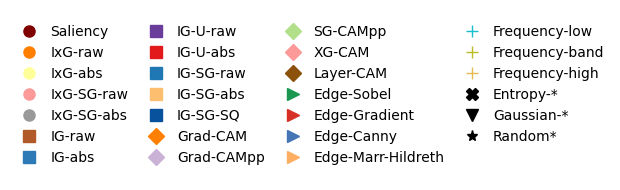

In [10]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

handles = []
labels  = []

for method, st in method_styles.items():
    h = Line2D([], [], color=st['color'], marker=st['marker'],
               linestyle='', markersize=8)
    handles.append(h)
    labels.append(method)

dummy_entries = [
    ('Entropy-*',    {'color':'black','marker':'X'}),
    ('Gaussian-*',   {'color':'black','marker':'v'}),
    ('Random*',      {'color':'black','marker':'*'}),
]
for name, st in dummy_entries:
    handles.append(Line2D([], [], color=st['color'], marker=st['marker'],
                          linestyle='', markersize=8))
    labels.append(name)

fig_leg = plt.figure(figsize=(6, 2))
ax_leg  = fig_leg.add_subplot(1,1,1)

ax_leg.legend(
    handles,
    labels,
    loc='center',
    ncol=4,
    frameon=False,
    fontsize=10,
    columnspacing=1.0,       # tweak spacing between columns
    handletextpad=0.5        # tweak spacing between marker and label
)

ax_leg.axis('off')
fig_leg.tight_layout()
plt.show()
fig_leg.savefig('legend.jpeg', dpi=300, bbox_inches='tight')